# O som do batimento cardíaco
### Fabio Ferreira de Lima
Trabalho de Conclusão de Curso apresentado na Escola de Economia de São Paulo
da Fundação Getúlio Vargas, para obtenção do certificado de conclusão de curso de especialização em Business Analytics e Big Data

#### Processamento de som básico com Python
Aqui vamos descrever como executar algumas funções básicas de processamento de som no Python. Usaremos a interface pylab, que dá acesso ao numpy e ao matplotlib. Ambos os pacotes precisam ser instalados.

Começaremos importando os pacotes necessários, supondo que eles já tenham sido instalados corretamente. Vamos carregar a biblioteca de ondas e usá-la para abrir um arquivo de som.

In [1]:
from scipy.io import wavfile
from pylab import*
import struct

Em seguida, vamos ler um arquivo wav. utilizaremos um arquivo da própria base "heartbeat sound"como exemplo o a0007.wav, encontrado dentro da pasta training-a. Esse é um exemplo de batimento 'Normal' da base.

In [2]:
sf, PCG_Normal = wavfile.read('../heartsound/training/training-a/a0007.wav')

PCG_Normal mostra um array com as leituras do arquivo wav por frame

In [3]:
PCG_Normal

array([1454, 3040, 2689, ...,  452,  415,  419], dtype=int16)

sf mostra os frames por segundo do arquivo. No nosso caso, os arquivos possuem 2000 frames por segundo.

In [4]:
sf

2000

Agora podemos dar uma olhada na forma de onda.

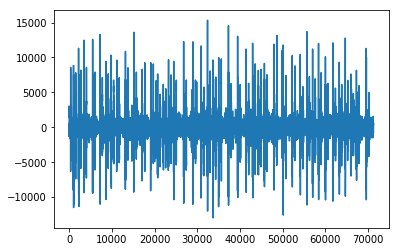

In [5]:
plot(PCG_Normal )
show()

Vamos ler mais um exemplo, dessa vez um batimento 'Abnormal' (arquivo a0001.wav), para compararmos as diferenças dos dois batimentos

In [6]:
fs, PCG_Anormal = wavfile.read('../heartsound/training/training-a/a0001.wav')

Agora podemos as duas ondas (Normal x Abnormal). Para facilitar, vamos plotar apenas os primeiros 3 segundos de cada arquivo de audio.

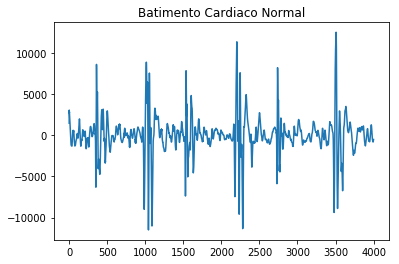

In [7]:
plot(PCG_Normal[0:sf*2])
title ('Batimento Cardiaco Normal')
show()

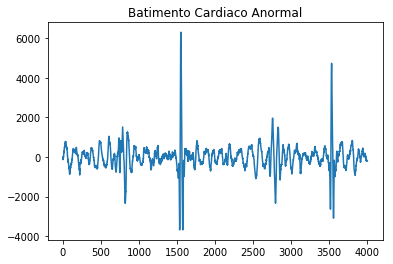

In [9]:
plot(PCG_Anormal[0:sf*2])
title ('Batimento Cardiaco Anormal')
show()

## Modelando o batimento cardíaco

In [9]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.signal import decimate
from sklearn.model_selection import train_test_split

In [10]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, GlobalAvgPool1D, Dropout, BatchNormalization, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.utils import np_utils
from keras.regularizers import l2

Using TensorFlow backend.


In [11]:
INPUT_LIB_a = '../heartsound/training/training-a/'
INPUT_LIB_b = '../heartsound/training/training-b/'
INPUT_LIB_c = '../heartsound/training/training-c/'
INPUT_LIB_d = '../heartsound/training/training-d/'
INPUT_LIB_e = '../heartsound/training/training-e/'
INPUT_LIB_f = '../heartsound/training/training-f/'
SAMPLE_RATE = 44100
CLASSES = ['Normal','Abnormal']
CODE_BOOK = {x:i for i,x in enumerate(CLASSES)}   
NB_CLASSES = len(CLASSES)

#### Carregando os dados
Como a base de sons fornecida possui uma grande quantidade de arquivos "não classificados", decidi tirar esses arquivos da amostra e criar o modelo apenas com os arquivos classificados. Por enquanto, também faremos com que todas as séries temporais tenham o mesmo comprimento. Faremos tudo isso definindo as funções dos elementos, que podemos passar para o Pandas.

In [12]:
def load_wav_file(name, path):
    sampFreq, b = wavfile.read(path + name)
    return b

In [13]:
def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, and makes datatype float"""
    result = np.empty((length, ), dtype = 'float32')
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

In [14]:
df_a = pd.read_csv('NEW_REFERENCE_A.csv')
df_a['time_series'] = df_a['fname'].apply(load_wav_file, path=INPUT_LIB_a )    
df_a['len_series'] = df_a['time_series'].apply(len)
MAX_LEN = max(df_a['len_series'])
df_a['time_series'] = df_a['time_series'].apply(repeat_to_length, length=MAX_LEN)

In [15]:
df_a.head(3)

,file,category,label,fname,time_series,len_series
0,a0001,1,Abnormal,a0001.wav,"[-69.0, -135.0, -104.0, -25.0, -63.0, -3.0, 30...",71332
1,a0002,1,Abnormal,a0002.wav,"[297.0, 728.0, 779.0, 802.0, 590.0, 242.0, 187...",41657
2,a0003,1,Abnormal,a0003.wav,"[-126.0, -306.0, -265.0, -310.0, -300.0, -332....",61440


In [16]:
df_a.dtypes

file           object
 category       int64
label          object
fname          object
time_series    object
len_series      int64
dtype: object

In [17]:
df_a['label'].value_counts()

Abnormal    292
Normal      117
Name: label, dtype: int64

#### Converter dados em matrizes numpy
Como mencionado anteriormente, não vamos utilizar os arquivos não classificados no conjunto de treinamento e validação. Vamos zerar a série temporal no final para obter o mesmo comprimento e coletar todos os arrays 2D numpy, que podem ser usados para o treinamento de redes neurais.

In [19]:
x_data_a = np.stack(df_a['time_series'].values, axis=0)

In [20]:
len(x_data_a)

409

In [21]:
x_data_a

array([[  -69.,  -135.,  -104., ...,   -81.,   -66.,   -96.],
       [  297.,   728.,   779., ...,   206.,   220.,   226.],
       [ -126.,  -306.,  -265., ...,   -69.,   -82.,   -31.],
       ..., 
       [ -119.,  -204.,   -81., ...,  1557.,  1650.,  1674.],
       [ -291.,  -635.,  -598., ...,  -417.,  -326.,  -220.],
       [-1003., -2023., -1708., ...,   201.,   150.,   132.]], dtype=float32)

Vou considerar apenas os 4 primeiros segundos de cada audio para a criação do modelo, o que dá a leitura de 8000 frames por audio.

In [22]:
x_data_a [:,:10]

array([[  -69.,  -135.,  -104., ...,   -22.,    26.,    77.],
       [  297.,   728.,   779., ...,   134.,   139.,    97.],
       [ -126.,  -306.,  -265., ...,  -341.,  -333.,  -331.],
       ..., 
       [ -119.,  -204.,   -81., ...,   262.,   309.,   412.],
       [ -291.,  -635.,  -598., ...,  -702.,  -738.,  -768.],
       [-1003., -2023., -1708., ..., -1717., -1638., -1526.]], dtype=float32)

In [23]:
np.savetxt("x_data_a.csv", x_data_a [:,:8000], delimiter=",")

Exportando todas as bases

In [24]:
# Data set traning-b
df_b = pd.read_csv('NEW_REFERENCE_B.csv')
df_b['time_series'] = df_b['fname'].apply(load_wav_file, path=INPUT_LIB_b )    
df_b['len_series'] = df_b['time_series'].apply(len)
MAX_LEN = max(df_b['len_series'])
df_b['time_series'] = df_b['time_series'].apply(repeat_to_length, length=MAX_LEN)
x_data_b = np.stack(df_b['time_series'].values, axis=0)
np.savetxt("x_data_b.csv", x_data_b [:,:8000], delimiter=",")

In [25]:
# Data set traning-c
df_c = pd.read_csv('NEW_REFERENCE_C.csv')
df_c['time_series'] = df_c['fname'].apply(load_wav_file, path=INPUT_LIB_c )    
df_c['len_series'] = df_c['time_series'].apply(len)
MAX_LEN = max(df_c['len_series'])
df_c['time_series'] = df_c['time_series'].apply(repeat_to_length, length=MAX_LEN)
x_data_c = np.stack(df_c['time_series'].values, axis=0)
np.savetxt("x_data_c.csv", x_data_c [:,:8000], delimiter=",")

In [26]:
# Data set traning-d
df_d = pd.read_csv('NEW_REFERENCE_D.csv')
df_d['time_series'] = df_d['fname'].apply(load_wav_file, path=INPUT_LIB_d )    
df_d['len_series'] = df_d['time_series'].apply(len)
MAX_LEN = max(df_d['len_series'])
df_d['time_series'] = df_d['time_series'].apply(repeat_to_length, length=MAX_LEN)
x_data_d = np.stack(df_d['time_series'].values, axis=0)
np.savetxt("x_data_d.csv", x_data_d [:,:8000], delimiter=",")

In [27]:
# Data set traning-e
df_e = pd.read_csv('NEW_REFERENCE_E.csv')
df_e['time_series'] = df_e['fname'].apply(load_wav_file, path=INPUT_LIB_e )    
df_e['len_series'] = df_e['time_series'].apply(len)
MAX_LEN = max(df_e['len_series'])
df_e['time_series'] = df_e['time_series'].apply(repeat_to_length, length=MAX_LEN)
x_data_e = np.stack(df_e['time_series'].values, axis=0)
np.savetxt("x_data_e.csv", x_data_e [:,:8000], delimiter=",")

In [28]:
# Data set traning-f
df_f = pd.read_csv('NEW_REFERENCE_F.csv')
df_f['time_series'] = df_f['fname'].apply(load_wav_file, path=INPUT_LIB_f )    
df_f['len_series'] = df_f['time_series'].apply(len)
MAX_LEN = max(df_f['len_series'])
df_f['time_series'] = df_f['time_series'].apply(repeat_to_length, length=MAX_LEN)
x_data_f = np.stack(df_f['time_series'].values, axis=0)
np.savetxt("x_data_f.csv", x_data_f [:,:8000], delimiter=",")

In [ ]:
new_labels = np.array(df[' category'].values, dtype='int')
y_data = np_utils.to_categorical(new_labels )

In [ ]:
y_data

In [ ]:
x_train, x_test, y_train, y_test, train_filenames, test_filenames = \
    train_test_split(x_data, y_data, df['fname'].values, test_size=0.20)

Agora reduzimos os dados com o que é, na verdade, um filtro de baixa passagem muito agressivo. Isso não é necessário para o tempo computacional, mas parece melhorar a generalização neste conjunto de dados. Com mais dados, devemos remover ou reduzir essa etapa e, em vez disso, adicionar 2-5 camadas extras de convolução. A razão pela qual isso funciona é provavelmente que o que você ouve no estetoscópio é quase exclusivamente sons de baixa frequência, especialmente murmúrios.

In [ ]:
x_train = decimate(x_train, 8, axis=1, zero_phase=True)
x_train = decimate(x_train, 8, axis=1, zero_phase=True)
x_train = decimate(x_train, 4, axis=1, zero_phase=True)
x_test = decimate(x_test, 8, axis=1, zero_phase=True)
x_test = decimate(x_test, 8, axis=1, zero_phase=True)
x_test = decimate(x_test, 4, axis=1, zero_phase=True)

In [ ]:
# Escale cada observação para a variância unitária, ela já deve ter uma média próxima de zero.
x_train = x_train / np.std(x_train, axis=1).reshape(-1,1)
x_test = x_test / np.std(x_test, axis=1).reshape(-1,1)

Keras quer que os dados tenham uma dimensão de canal, análoga ao RGB para reconhecimento de imagem. Vamos adicionar isso.

In [ ]:
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

### Trainando o modelo

In [ ]:
model = Sequential()
model.add(Conv1D(filters=4, kernel_size=9, activation='relu',
                input_shape = x_train.shape[1:],
                kernel_regularizer = l2(0.025)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=4, kernel_size=9, activation='relu',
                kernel_regularizer = l2(0.05)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=9, activation='relu',
                 kernel_regularizer = l2(0.1)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=9, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv1D(filters=32, kernel_size=1, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.75))
model.add(GlobalAvgPool1D())
model.add(Dense(2, activation='softmax'))

Esta versão da rede tem 5.000 parâmetros, e pode facilmente ajustar o nosso conjunto de dados de 125 séries temporais se permitirmos que ele seja executado por muito tempo.

In [ ]:
def batch_generator(x_train, y_train, batch_size):
    """
    Rotates the time series randomly in time
    """
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    full_idx = range(x_train.shape[0])
    
    while True:
        batch_idx = np.random.choice(full_idx, batch_size)
        x_batch = x_train[batch_idx]
        y_batch = y_train[batch_idx]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch

In [ ]:
weight_saver = ModelCheckpoint('set_a_weights.h5', monitor='val_loss', 
                               save_best_only=True, save_weights_only=True)

In [ ]:
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8**x)

In [ ]:
hist = model.fit_generator(batch_generator(x_train, y_train, 8),
                   epochs=30, steps_per_epoch=1000,
                   validation_data=(x_test, y_test),
                   callbacks=[weight_saver, annealer],
                   verbose=2)

Vamos trazer de volta os melhores pesos, caso tenhamos "overfitted".

In [ ]:
model.load_weights('set_a_weights.h5')

#### Evaluation

In [ ]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [ ]:
y_hat = model.predict(x_test)
np.set_printoptions(precision=2, suppress=True)
for i in range(3):
    plt.plot(y_hat[:,i], c='r')
    plt.plot(y_test[:,i], c='b')
    plt.show()
    print(CLASSES[i])

In [ ]:
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_test, axis=1)
for i in range(len(y_true)):
    if y_pred[i] != y_true[i]:
        print("File: {}, Pred: {}, True: {}".format(
            test_filenames[i],
            CLASSES[y_pred[i]], CLASSES[y_true[i]]))
        plt.plot(x_test[i])
        plt.show()